In [ ]:
import os
import random
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [ ]:
# 重みの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:  # 畳み込み層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:  # 全結合層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:  # バッチノーマライゼーションの場合
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=100, nch_g=64, nch=3):
        '''
        nz: 入力ベクトルzの次元
        nch_g: 最終層の入力チャネル数
        nch: 出力画像のチャネル数
        '''
        super().__init__()
        
        # NNの構造を定義
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.ConvTranspose2d(nz, nch_g * 8, 4, 1, 0),
                nn.BatchNorm2d(nch_g * 8),
                nn.LeakyReLU()
            ),  # (B, nz, 1, 1) -> (B, nch_g*8, 4, 4)
            'layer1': nn.Sequential(
                nn.ConvTranspose2d(nch_g * 8, nch_g * 4, 4, 2, 1),
                nn.BatchNorm2d(nch_g * 4),
                nn.Dropout2d(p=0.3),
                nn.LeakyReLU()
            ),  # (B, nch_g*8, 4, 4) -> (B, nch_g*4, 8, 8)
            'layer2': nn.Sequential(
                nn.ConvTranspose2d(nch_g * 4, nch_g * 2, 4, 2, 1),
                nn.BatchNorm2d(nch_g * 2),
                nn.LeakyReLU()
            ),  # (B, nch_g*4, 8, 8) -> (B, nch_g*2, 16, 16)

            'layer3': nn.Sequential(
                nn.ConvTranspose2d(nch_g * 2, nch_g, 4, 2, 1),
                nn.BatchNorm2d(nch_g),
                nn.Dropout2d(),
                nn.LeakyReLU()
            ),  # (B, nch_g*2, 16, 16) -> (B, nch_g, 32, 32)
            'layer4': nn.Sequential(
                nn.ConvTranspose2d(nch_g, nch, 4, 2, 1),
                nn.Tanh()
            )   # (B, nch_g, 32, 32) -> (B, nch, 64, 64)
        })

    def forward(self, z):
        '''
        param z: 入力ベクトル
        return: 生成画像
        '''
        for layer in self.layers.values():  # self.layersの各層で演算
            z = layer(z)
        return z

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nch=3, nch_d=64):
        '''
        nch: 入力画像のチャネル数
        nch_d: 先頭層の出力チャネル数
        '''
        super().__init__()

        # NNの構造を定義
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.Conv2d(nch, nch_d, 4, 2, 1),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch, 64, 64) -> (B, nch_d, 32, 32)
            'layer1': nn.Sequential(
                nn.Conv2d(nch_d, nch_d * 2, 4, 2, 1),
                nn.BatchNorm2d(nch_d * 2),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d, 32, 32) -> (B, nch_d*2, 16, 16)
            'layer2': nn.Sequential(
                nn.Conv2d(nch_d * 2, nch_d * 4, 4, 2, 1),
                nn.BatchNorm2d(nch_d * 4),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d*2, 16, 16) -> (B, nch_d*4, 8, 8)
            'layer3': nn.Sequential(
                nn.Conv2d(nch_d * 4, nch_d * 8, 4, 2, 1),
                nn.BatchNorm2d(nch_d * 8),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d*4, 8, 8) -> (B, nch_g*8, 4, 4)
            'layer4': nn.Conv2d(nch_d * 8, 1, 4, 1, 0)
            # (B, nch_d*8, 4, 4) -> (B, 1, 1, 1)
        })

    def forward(self, x):
        '''
        x: 元画像あるいは贋作画像
        return: 識別信号
        '''
        for layer in self.layers.values():  # self.layersの各層で演算
            x = layer(x)
        return x.squeeze()  # Tensorの形状を(B)に変更して返す

In [ ]:
# カテゴリカル変数のラベルをOne-Hoe形式に変換
def onehot_encode(label, device, n_class=10):
    '''
    label: 変換対象のラベル
    n_class: ラベルのクラス数
    '''
    eye = torch.eye(n_class, device=device)
    return eye[label].view(-1, n_class, 1, 1)  #ランダムベクトルあるいは画像と連結するために(B, c_class, 1, 1)のTensorにして返す

In [ ]:
# 画像とラベルを連結
def concat_image_label(image, label, device, n_class=10):
    B, C, H, W = image.shape    # 画像Tensorの大きさを取得
    
    oh_label = onehot_encode(label, device)  # ラベルをOne-Hotベクトル化
    oh_label = oh_label.expand(B, n_class, H, W)  # 画像のサイズに合わせるようラベルを拡張
    return torch.cat((image, oh_label), dim=1)  # 画像とラベルをチャネル方向（dim=1）で連結して返す

In [ ]:
# ノイズ（ランダムベクトル）とラベルを連結
def concat_noise_label(noise, label, device):
    oh_label = onehot_encode(label, device)  # ラベルをOne-Hotベクトル化
    return torch.cat((noise, oh_label), dim=1)  # ノイズとラベルをチャネル方向（dim=1）で連結して返す

In [ ]:
workers = 2
batch_size = 50
nz = 100
nch_g = 64
nch_d = 64
n_epoch = 200
lr = 0.0002
beta1 = 0.5
outf = './result_cgan'
display_interval = 100

try:
    os.makedirs(outf)
except OSError:
    pass

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
trainset = dset.STL10(root='./dataset/stl10_root', download=True, split='train',
                      transform=transforms.Compose([
                          transforms.RandomResizedCrop(64, scale=(88/96, 1.0), ratio=(1., 1.)),
                          transforms.RandomHorizontalFlip(),
                          transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                      ]))  # ラベルを使用するのでunlabeledを含めない
testset = dset.STL10(root='./dataset/stl10_root', download=True, split='test',
                     transform=transforms.Compose([
                         transforms.RandomResizedCrop(64, scale=(88/96, 1.0), ratio=(1., 1.)),
                         transforms.RandomHorizontalFlip(),
                         transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                     ]))
dataset = trainset + testset

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=int(workers))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

In [ ]:
# 生成器G。ランダムベクトルとラベルを連結したベクトルから贋作画像を生成
netG = Generator(nz=nz+10, nch_g=nch_g).to(device)  # 入力ベクトルの次元は、ランダムベクトルの次元nzにクラス数10を加算したもの
netG.apply(weights_init)
print(netG)

Generator(
  (layers): ModuleDict(
    (layer0): Sequential(
      (0): ConvTranspose2d(110, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (layer1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout2d(p=0.3, inplace=False)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (layer2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (layer3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
# 識別器D。画像とラベルを連結したTensorが、元画像か贋作画像かを識別
netD = Discriminator(nch=3+10, nch_d=nch_d).to(device)  # 入力Tensorのチャネル数は、画像のチャネル数3にクラス数10を加算したもの
netD.apply(weights_init)
print(netD)

Discriminator(
  (layers): ModuleDict(
    (layer0): Sequential(
      (0): Conv2d(13, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer4): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)


In [ ]:
criterion = nn.MSELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

fixed_label = [i for i in range(10)] * (batch_size // 10)  # 確認用のラベル。0〜9のラベルの繰り返し
fixed_label = torch.tensor(fixed_label, dtype=torch.long, device=device)

fixed_noise_label = concat_noise_label(fixed_noise, fixed_label, device)  # 確認用のノイズとラベルを連結

In [ ]:
G_losses = []
D_losses = []

# 学習のループ
for epoch in range(n_epoch):
    for itr, data in enumerate(dataloader):
        real_image = data[0].to(device)  # 元画像
        real_label = data[1].to(device)  # 元画像に対応するラベル
        real_image_label = concat_image_label(real_image, real_label, device)  # 元画像とラベルを連結

        sample_size = real_image.size(0)
        noise = torch.randn(sample_size, nz, 1, 1, device=device)
        fake_label = torch.randint(10, (sample_size,), dtype=torch.long, device=device)  # 贋作画像生成用のラベル
        fake_noise_label = concat_noise_label(noise, fake_label, device)  # ノイズとラベルを連結
        
        real_target = torch.full((sample_size,), 1., device=device)
        fake_target = torch.full((sample_size,), 0., device=device)

        ############################
        # 識別器Dの更新
        ###########################
        netD.zero_grad()

        output = netD(real_image_label)  # 識別器Dで元画像とラベルの組み合わせに対する識別信号を出力
        errD_real = criterion(output, real_target)        
        D_x = output.mean().item()

        fake_image = netG(fake_noise_label)  # 生成器Gでラベルに対応した贋作画像を生成
        fake_image_label = concat_image_label(fake_image, fake_label, device)  # 贋作画像とラベルを連結

        output = netD(fake_image_label.detach())  # 識別器Dで贋作画像とラベルの組み合わせに対する識別信号を出力
        errD_fake = criterion(output, fake_target)
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        ############################
        # 生成器Gの更新
        ###########################
        netG.zero_grad()
        
        output = netD(fake_image_label)  # 更新した識別器Dで改めて贋作画像とラベルの組み合わせに対する識別信号を出力
        errG = criterion(output, real_target)
        errG.backward()
        D_G_z2 = output.mean().item()
        
        optimizerG.step()

        if itr % display_interval == 0:
            print('[{}/{}][{}/{}] Loss_D: {:.3f} Loss_G: {:.3f} D(x): {:.3f} D(G(z)): {:.3f}/{:.3f}'
                  .format(epoch + 1, n_epoch,
                          itr + 1, len(dataloader),
                          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())  
        D_losses.append(errD.item())

        if epoch == 0 and itr == 0:
            vutils.save_image(real_image, '{}/real_samples.png'.format(outf),
                              normalize=True, nrow=10)

    ############################
    # 確認用画像の生成
    ############################
    fake_image = netG(fixed_noise_label)  # 1エポック終了ごとに、指定したラベルに対応する贋作画像を生成
    vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch + 1),
                      normalize=True, nrow=10)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Lossの表示
plt.figure(figsize=(10,5))
plt.title('Generator and Discriminator Loss During Training')
plt.plot(G_losses,label='G')
plt.plot(D_losses,label='D')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib
import matplotlib.animation as animation
from IPython.display import HTML

# メモリの確保
matplotlib.rcParams['animation.embed_limit'] = 2**128

# 画像格納
img_list = []
for epoch in range(n_epoch):
    img = plt.imread('{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch + 1))
    img_list.append(img)

# gif表示
fig = plt.figure(figsize=(10,10))
plt.axis('off')
ims = [[plt.imshow(i, animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# gif保存
ani.save('{}/fake_imgs.gif'.format(outf), writer="pillow", fps=5)

plt.close()

HTML(ani.to_jshtml())

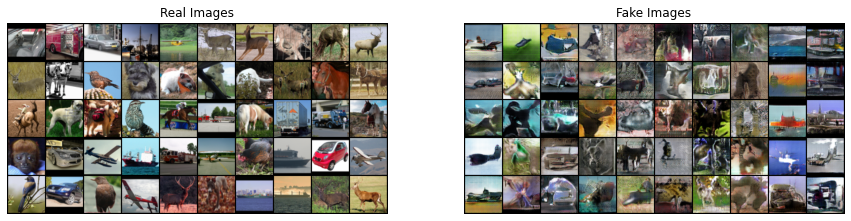

In [ ]:
from PIL import Image
plt.figure(figsize=(15,15))

# Real Imagesの表示
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Real Images')
img = Image.open('{}/real_samples.png'.format(outf))
plt.imshow(img)

# Fake Imagesの表示
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Fake Images')
plt.imshow(img_list[-1])
plt.show()